In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def make_activation_heatmap(model, img_array ,label,  last_conv_layer_name, classifier_layer_names):

  ''' We get an image array (already preprocessed) and generate a heatmap for it showing which parts where considered by the
  model while making its decision '''


  #making prediction on the model to see what the decision is
  pred = model.predict(img_array)
  print(f"Model's prediction : {np.argmax(pred)}")
  print(f"Actual label : {label}")

  #dividing the model into two parts - feature extraction model and classifier model
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output) # feature extraction model

  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x) # feature extraction model

  #Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.
  with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array) # output of last conv layer
    tape.watch(last_conv_layer_output) # compute gradients
    preds = classifier_model(last_conv_layer_output) # output of the classification w.r.t. last conv layer
    top_pred_index = tf.argmax(preds[0]) # index of highest prediction class to identify which class to focus upon
    top_class_channel = preds[:, top_pred_index]  # extract the score corresponding to the top predicted class across the batch.

  grads = tape.gradient(top_class_channel, last_conv_layer_output) # Computes the gradient of the top_class_channel (target class score) with respect to the last_conv_layer_output (feature maps).

  #Now we apply pooling and importance weighting to the gradient tensor to obtain our heatmap of class activation.
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # making a standalone class activation heatmap
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)

  #Superimposing the heatmap on the original picture
  img = np.squeeze(img_array, axis=0)

  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)

  # Display the image
  plt.imshow(superimposed_img)
  plt.show()

In [6]:
# the following code was taken from the keras documentation : https://keras.io/api/data_loading/image/
data_dir = "/content/drive/MyDrive/Colab Notebooks/chest_xray_multiclass"

train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

training_data = image_dataset_from_directory(
    train_dir,
    labels='inferred', # the labels are inferred
    label_mode='int',
    batch_size=32,
    image_size=(224,224)
    )

test_data = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224,224)
    )

Found 5232 files belonging to 3 classes.
Found 624 files belonging to 3 classes.


In [7]:
# Function to extract features (X) and labels (y) from a dataset
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert image tensors to NumPy arrays
        labels.append(label_batch.numpy())  # Convert label tensors to NumPy arrays
    return np.concatenate(images), np.concatenate(labels)

# Extract training data
X_train, y_train = dataset_to_numpy(training_data)

# Extract test data
X_test, y_test = dataset_to_numpy(test_data)


In [8]:
# sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5232, 224, 224, 3)
(5232,)
(624, 224, 224, 3)
(624,)


In [ ]:
print(X_train.min(), X_train.max())
print(np.unique(y_train))

0.0 255.0
[0 1 2]


In [ ]:
# preprocessing
# from integers in [0,255] to float in [0,1]
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32') / 255

In [ ]:
print(X_train.min(), X_train.max())
print(np.unique(y_train))

0.0 0.003921569
[0 1 2]


In [ ]:
# Baseline Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= X_train.shape[1:], name = "firstConvLayer"))
model.add(layers.MaxPooling2D((2,2), name = "firstMaxPoolLayer"))
model.add(layers.Conv2D(64, (3, 3), activation='relu', name = "secondConvLayer"))
model.add(layers.MaxPooling2D((2,2), name = "secondMaxPoolLayer"))
model.add(layers.Flatten(name = "flatteningLayer"))
model.add(layers.Dense(64, activation='relu', name = "firstDenseLayer"))
# output layer
model.add(layers.Dense(3, activation='softmax', name = "predictionLayer"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ firstConvLayer (Conv2D)              │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ firstMaxPoolLayer (MaxPooling2D)     │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ secondConvLayer (Conv2D)             │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ secondMaxPoolLayer (MaxPooling2D)    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatteningLayer (Flatten)            │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ firstDenseLayer (Dense)              │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictionLayer (Dense)              │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,587 (45.64 MB)

 Trainable params: 11,963,587 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# making callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split = 0.3, callbacks = [early_stopping])

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7399 - loss: 0.5876 - val_accuracy: 0.5833 - val_loss: 0.7458
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7574 - loss: 0.5441 - val_accuracy: 0.4583 - val_loss: 0.8504
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7635 - loss: 0.5330 - val_accuracy: 0.4583 - val_loss: 1.4542
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7698 - loss: 0.5268 - val_accuracy: 0.6250 - val_loss: 0.7493
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7730 - loss: 0.5074 - val_accuracy: 0.6250 - val_loss: 0.8589
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7671 - loss: 0.5254 - val_accuracy: 0.6667 - val_loss: 0.7253
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.7776 - loss: 0.5055 - val_accuracy: 0.5000 - val_loss: 1.3388
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.7706 - loss: 0.5111 - val_accuracy: 0.6250

# **Grad-CAM for Visualizing the Decisions Made by Our Model**

This notebook follows the technique shared by Francois Chollet in the book 'Deep Learning with Python, Second Edition'.

Grad-CAM is a technique that is useful for understanding which parts of a given image led a convnet to its final classification decision. This is helpful for “debugging” the decision process of a convnet, particularly in the case of a classification mistake (a problem domain called model interpretability).

It creates a class activation heatmap which shows how important each input location is with respect to the class under consideration.

In [ ]:
# using an image from the test dataset to visualize the decision of the model
img = X_test[1] # this is already pre-processed which is convenient
img = np.expand_dims(img, axis=0) # adding the batch dimension
print(img.shape)

(1, 224, 224, 3)


Now we will see which part of the image led to the model's decision.

First, we create a model that maps the input image to the activations of the last convolutional layer. Reason being that we want to see what parts of the image lead to the final prediction. And the last convolutional layer contains the most informative features of an image.

The last conv layer will be used to build a submodel (last_conv_layer_model) that outputs the feature maps at this layer.
These feature maps are critical for visualizing what the model "sees" in the input image.

Second, we create a model that maps the activations of the last convolutional layer to the final class predictions.

Then we compute the gradient of the top predicted class for our input image with respect to the activations of the last convolution layer.

Grad-CAM requires the gradient of the target class score with respect to the feature maps from the last convolutional layer.

In [ ]:
last_conv_layer_name = 'secondConvLayer' # the last feature extracting layer
classifier_layers_names = [ # layers that classify the extracted features - they come after the last convolutional layer
    "secondMaxPoolLayer",
     "flatteningLayer",
    "firstDenseLayer",
    "predictionLayer"
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Model's prediction : 1
Actual label : 1


<ipython-input-48-2bd9f69ab746>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


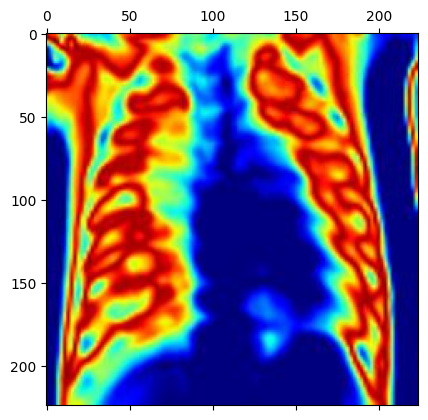

In [ ]:
make_activation_heatmap(model, img, y_test[1], last_conv_layer_name, classifier_layers_names )